In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def event_diff(spark, prefix, from_event, to_event, **kwargs):
    txn_info = transactions_csv(spark, prefix, **kwargs)\
        .drop("min_received_at", "max_received_at", "sent_at", "received_at")\
        .withColumn("num_replicas", F.size(col("replicas")))\
        .withColumn("num_partitions", F.size(col("partitions")))\
        .withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))
    txn_events = txn_events_csv(spark, prefix)\
        .where(col("event").isin([from_event, to_event]))\
        .groupBy("txn_id", "machine").pivot("event").max("time")\
        .select(
            "txn_id",
            "machine",
#             "home",
            ((col(to_event) - col(from_event)) / 1000000).alias(f"diff")
        )\
        .dropna()
    return txn_events.join(txn_info, on="txn_id")


def plot_cdf_per_region(axes, df, col, **kwargs):
    cols = axes.shape[1]
    for i in range(axes.size):
        r, c = i // cols, i % cols
        arr = df.loc[df.coordinator_region == i, col]
        plot_cdf(ax[r, c], arr, linewidth=0, marker='o', **kwargs)
        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")


# Lock-hold time

In [33]:
PREFIX = "main/tpcc"
SAMPLE = 1.0
baseline_df = event_diff(spark, f"{PREFIX}/baseline-clients50", "ENTER_MULTI_HOME_ORDERER", "EXIT_MULTI_HOME_ORDERER", new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
# ddr_ts_df = event_diff(spark, f"{PREFIX}/ddr_ts-clients50", "ENTER_MULTI_HOME_ORDERER_IN_BATCH", "EXIT_MULTI_HOME_ORDERER", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()

## Overall

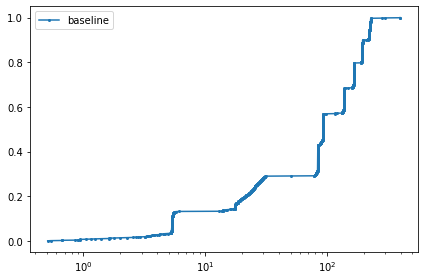

In [34]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df["diff"], label="baseline")
# plot_cdf(ax, ddr_ts_df["diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By type

### single-home

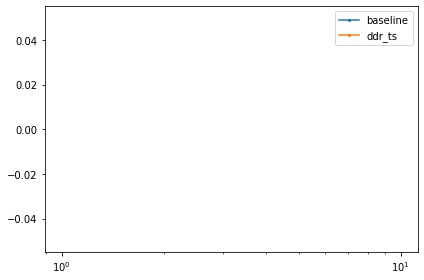

In [26]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df.loc[baseline_df["num_replicas"] == 1, "diff"], label="baseline")
plot_cdf(ax, ddr_ts_df.loc[ddr_ts_df["num_replicas"] == 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

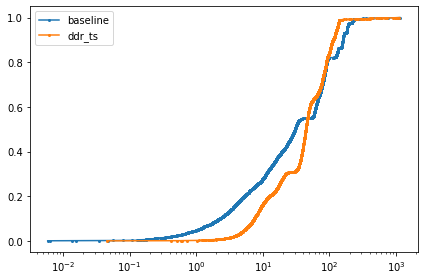

In [27]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df.loc[baseline_df["num_replicas"] > 1, "diff"], label="baseline")
plot_cdf(ax, ddr_ts_df.loc[ddr_ts_df["num_replicas"] > 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By region

### single-home

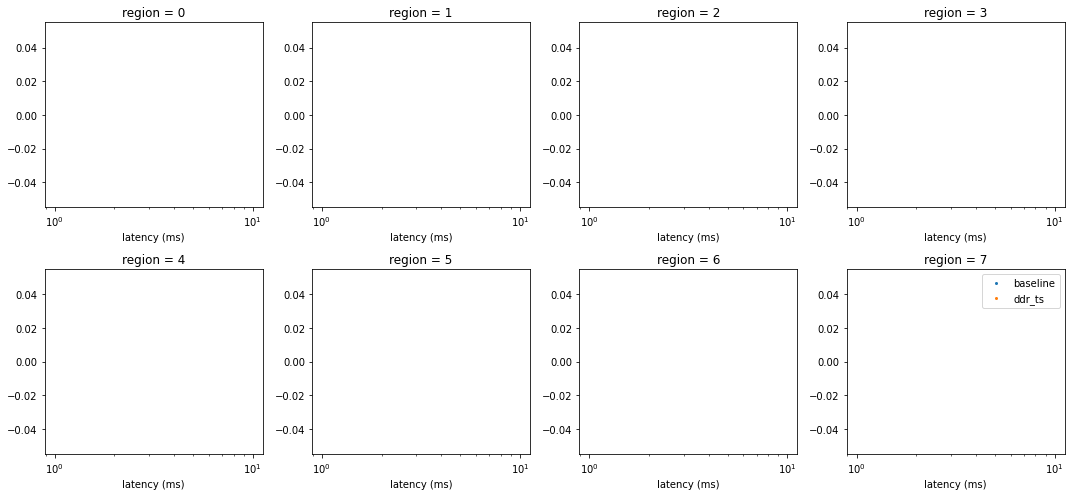

In [28]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, baseline_df[baseline_df["num_replicas"] == 1], "diff", label="baseline")
plot_cdf_per_region(ax, ddr_ts_df[ddr_ts_df["num_replicas"] == 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

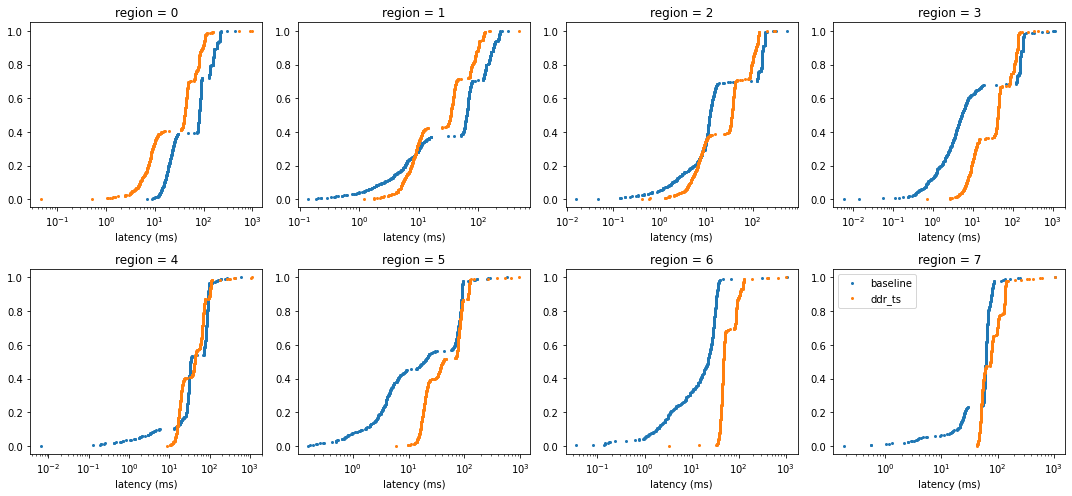

In [29]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, baseline_df[baseline_df["num_replicas"] > 1], "diff", label="baseline")
plot_cdf_per_region(ax, ddr_ts_df[ddr_ts_df["num_replicas"] > 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

# Sequencer

In [23]:
PREFIX = "main/tpcc"
SAMPLE = 1.0
seq_baseline_df = event_diff(spark, f"{PREFIX}/baseline-clients50", "ENTER_SEQUENCER", "ENTER_LOCAL_BATCH", new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
seq_ddr_ts_df = event_diff(spark, f"{PREFIX}/ddr_ts-clients50", "ENTER_SEQUENCER", "ENTER_LOCAL_BATCH", new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()

## Overall

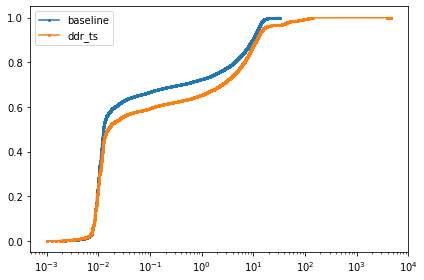

In [24]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df["diff"], label="baseline")
plot_cdf(ax, seq_ddr_ts_df["diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By type

### single-home

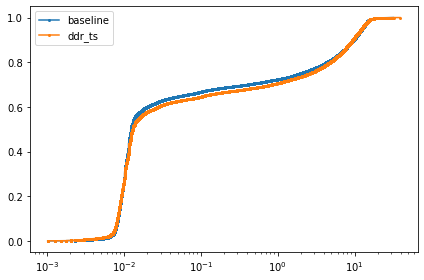

In [25]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df.loc[seq_baseline_df["num_replicas"] == 1, "diff"], label="baseline")
plot_cdf(ax, seq_ddr_ts_df.loc[seq_ddr_ts_df["num_replicas"] == 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

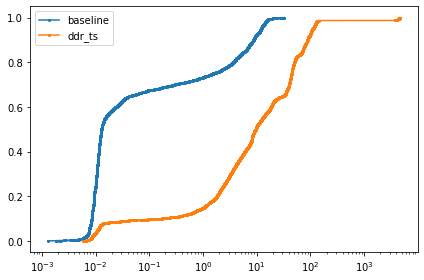

In [26]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df.loc[seq_baseline_df["num_replicas"] > 1, "diff"], label="baseline")
plot_cdf(ax, seq_ddr_ts_df.loc[seq_ddr_ts_df["num_replicas"] > 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By region

### single-home

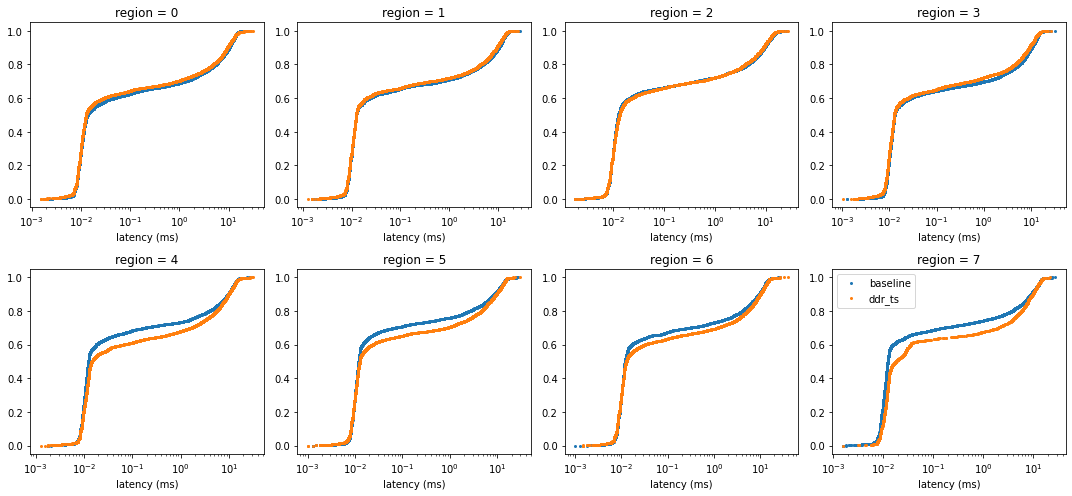

In [27]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, seq_baseline_df[seq_baseline_df["num_replicas"] == 1], "diff", label="baseline")
plot_cdf_per_region(ax, seq_ddr_ts_df[seq_ddr_ts_df["num_replicas"] == 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

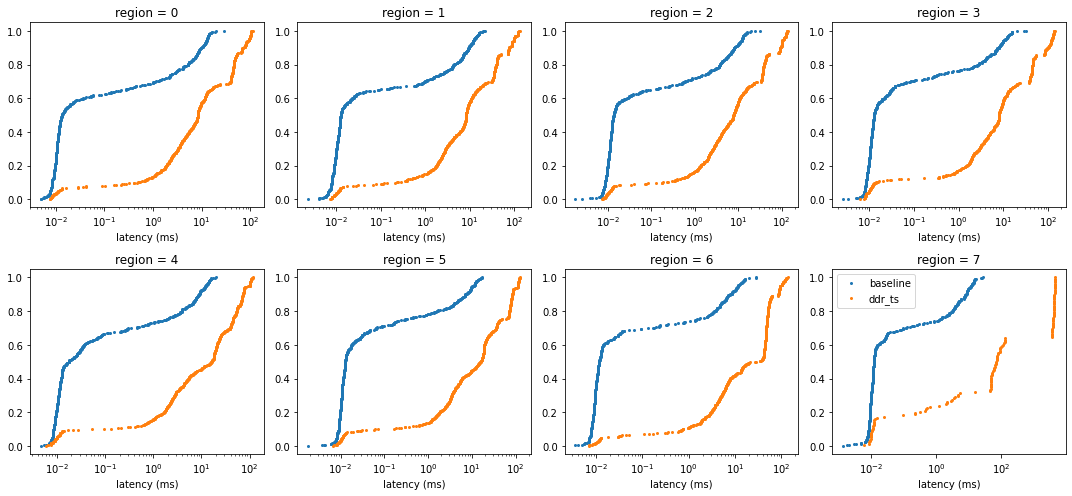

In [28]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, seq_baseline_df[seq_baseline_df["num_replicas"] > 1], "diff", label="baseline")
plot_cdf_per_region(ax, seq_ddr_ts_df[seq_ddr_ts_df["num_replicas"] > 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()